# Singular Value Threshold Projector

## Overview

Singular value threshold projectors project out singular vectors with singular values below or above a certain threshold. Suppose that we have access to a unitary $U$, its inverse $U^\dagger$ and the controlled reflection operators $(2\Pi - I)$, $(2\tilde{\Pi} - I)$. We are primarily interested in $A := \tilde{\Pi}U\Pi$, which has a singular value decomposition $A = W\Sigma V$. For $S \subset R$, let $\Sigma_S$ be the matrix obtained from $\Sigma$ by replacing all diagonal entries $\Sigma_{ii} \in S$ by one and all diagonal entries $\Sigma_{ii} \notin S$ by zero. We define $\Pi_S := \Pi V \Sigma_S V^\dagger \Pi$, and similarly $\tilde{\Pi}_S := \tilde{\Pi}W\Sigma_S W^\dagger\tilde{\Pi}$. For example, if we let $S=[0,\ell]$, $\Pi_S$ projects out right singular vectors with singular value at most $\ell$. These threshold projectors play a major role in quantum algorithms.

## Polynomial approximation

For numerical demonstration, we let $\ell = 0.5$. To implement $\Pi_{[0,0.5]}$, we can implement the singular value transformation of $A$ for a rectangle function $f$. We can call `cvx_poly_coef` from `optimization.utils` to find the best even polynomial approximating $f(x)$ on the interval $D_\delta = [0, 0.5-\delta] \cup [0.5+\delta,1]$, with $\delta = 0.05$. This subroutine uses convex optimization to solve the problem.

norm error = 6.529647593817857e-08
max of solution = 0.8999999998163493


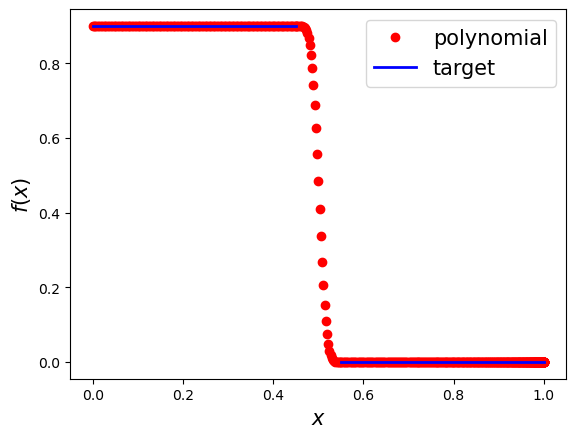

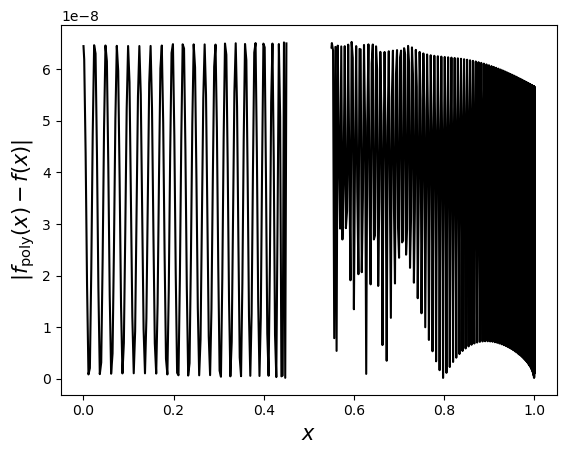

In [8]:
import numpy as np
from optimization.utils import cvx_poly_coef

delta = 0.05
opts = {
    'intervals': [0, 0.5-delta, 0.5+delta, 1],
    'objnorm': np.inf,
    'epsil': 0.1,
    'npts': 500,
    'fscale': 0.9,
    'maxiter': 100,
    'useReal': False,
    'targetPre': True,
    'isplot': True,
    'method': 'cvxpy'
}
targ = np.vectorize(lambda x: 1 if np.abs(x) < 0.5 else 0)
deg = 250
parity = deg % 2

coef = cvx_poly_coef(targ, deg, opts)
coef = coef[parity::2]

## Solve for phase factors and verify

iter err          
   1  +4.8372e-01
   2  +1.9792e-01
   3  +2.7183e-02
   4  +3.0104e-04
   5  +3.2273e-08
Stop criteria satisfied.
The residual error is
1.942890293094024e-14


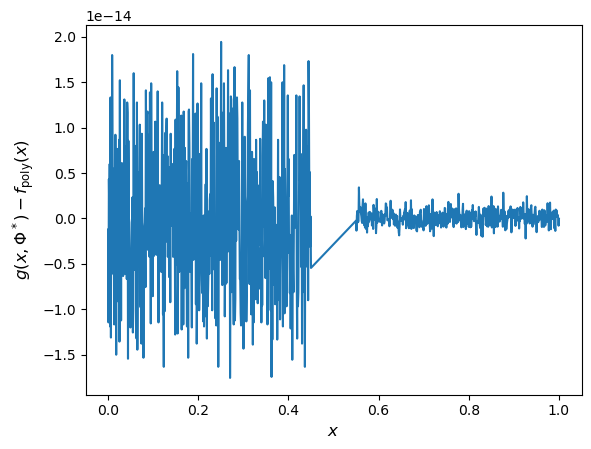

In [12]:
# Solve for phase factors
from optimization.QSP_solver import solve
opts['method'] = 'Newton'
phi_proc, out = solve(coef, parity, opts)

# Verify result
from optimization.utils import chebyshev_to_func
from optimization.core import get_entry
xlist1 = np.linspace(0, 0.5 - delta, 500)
xlist2 = np.linspace(0.5 + delta, 1, 500)
xlist = np.concatenate((xlist1, xlist2))
targ_value = targ(xlist)
func_value = chebyshev_to_func(xlist, coef, parity, True)
QSP_value = get_entry(xlist, phi_proc, out)
err = np.linalg.norm(QSP_value - func_value, np.inf)
print('The residual error is')
print(err)

# Plot error
import matplotlib.pyplot as plt
plt.plot(xlist, QSP_value - func_value)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$g(x,\\Phi^*)-f_\\mathrm{poly}(x)$', fontsize=12)
plt.show()

## Reference
1. Gilyén, A., Su, Y., Low, G. H., & Wiebe, N. (2019, June). Quantum singular value transformation and beyond: exponential improvements for quantum matrix arithmetics. In *Proceedings of the 51st Annual ACM SIGACT Symposium on Theory of Computing* (pp. 193-204).

2. Dong, Y., Meng, X., Whaley, K. B., & Lin, L. (2021). Efficient phase-factor evaluation in quantum signal processing. *Physical Review A*, 103(4), 042419.